In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

In [2]:
# CIFAR images are 32x32
# We consider a simple 2x2 jigsaw puzzle.
# 0 1
# 3 2
perm_inds = [(0, 0), (10, 0), (20, 0), (0, 10), (10, 10), (20, 10), (0, 20), (10, 20), (20, 20)]
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5
    
def permute2x2(images):
    """
    Splits the images into 3x3=9 pieces and randomly permutes the pieces.
    """
    p_images = torch.FloatTensor(images.size())
    perms = torch.LongTensor(images.size()[0], 9)
    for i in range(images.size()[0]):
        p = torch.randperm(9)
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            p_images[i, :, tr:tr+10, tc:tc+10] = images[i, :, sr:sr+10, sc:sc+10]
        perms[i,:] = p
    return(p_images, perms)

def restore2x2(p_images, perms):
    """
    Restores the original image from the pieces and the given permutation.
    """
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[perms[i, j]]
            images[i, :, sr:sr+10, sc:sc+10] = p_images[i, :, tr:tr+10, tc:tc+10]
    return images

def perm2vecmat2x2(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 9, 9)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(9):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)

def vecmat2perm2x2(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """
    n = x.size()[0]
    x = x.view(n, 9, 9)
    _, ind = x.max(2)
    return ind
    
def imshow(img, title=None):
    """
    Displays a torch image.
    """
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)

Files already downloaded and verified


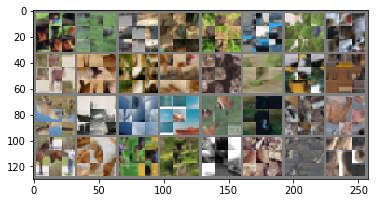

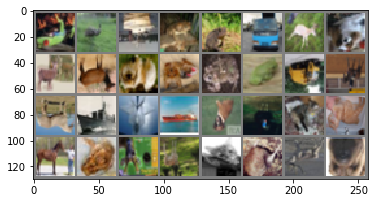

In [3]:
batch_size = 32
dataset_dir = './data'

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.Resize(90),
     transforms.ToTensor(),
     transforms.Normalize((img_mean, img_mean, img_mean), (img_std, img_std, img_std))])

train_set = torchvision.datasets.CIFAR10(root=dataset_dir, split='train', download=True, transform=transform)

# Plot some training samples.
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
dataiter = iter(sample_loader)
images, labels = next(dataiter)

p_images, perms = permute2x2(images)

# Check the implementation of perm2vecmat and vecmat2perm.
assert(vecmat2perm2x2(perm2vecmat2x2(perms)).equal(perms))

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms)))

In [4]:
# Prepare training, validation, and test samples.
validation_ratio = 0.1
total = len(train_set)
ind = list(range(total))
n_train = int(np.floor((1. - validation_ratio) * total))
train_ind, validation_ind = ind[:n_train], ind[n_train:]
train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_subsampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                sampler=validation_subsampler, num_workers=0)

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))

test_set = torchvision.datasets.CIFAR100(root=dataset_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

Number of training batches: 1407
Number of validation batches: 157
Files already downloaded and verified


In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def sinkhorn(A, n_iter=4):
    """
    Sinkhorn iterations.
    """
    for i in range(n_iter):
        A = A.clone()/A.sum(dim=1, keepdim=True)
        A = A.clone()/A.sum(dim=2, keepdim=True)
    return A

class SimpleConvNet(nn.Module):
    """
    A simple convolutional neural network shared among all pieces.
    """
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # 3 x 16 x 16 input
        self.conv1 = nn.Conv2d(3, 8, 3)
        # 8 x 14 x 14
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv2_bn = nn.BatchNorm2d(8)
        # 8 x 12 x 12
#         self.pool1 = nn.MaxPool2d(2, 2)
        # 8 x 6 x 6
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv3_bn = nn.BatchNorm2d(16)
        # 16 x 4 x 4
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        # 128-d features
        self.fc2 = nn.Linear(128, 64)
        self.fc2_bn = nn.BatchNorm1d(64)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn(self.conv2(x)))
#         x = self.pool1(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        return x

class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        super(JigsawNet, self).__init__()
        self.conv_net = SimpleConvNet()
        self.fc1 = nn.Linear(64 * 9, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(256, 81)
        self.sinkhorn_iter = sinkhorn_iter
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        x0 = self.conv_net(x[:, :, 0:10, 0:10])
        x1 = self.conv_net(x[:, :, 10:20, 0:10])
        x2 = self.conv_net(x[:, :, 20:30, 0:10])
        x3 = self.conv_net(x[:, :, 0:10, 10:20])
        x4 = self.conv_net(x[:, :, 10:20, 10:20])
        x5 = self.conv_net(x[:, :, 20:30, 10:20])
        x6 = self.conv_net(x[:, :, 0:10, 20:30])
        x7 = self.conv_net(x[:, :, 10:20, 20:30])
        x8 = self.conv_net(x[:, :, 20:30, 20:30])
        # Cat
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7, x8], dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        if self.sinkhorn_iter > 0:
            x = x.view(-1, 9, 9)
            x = sinkhorn(x, self.sinkhorn_iter)
            x = x.view(-1, 81)
        return x

In [6]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 4).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                optimizer.zero_grad()
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False).data[0]
                loss = criterion(outputs, y_in)
                loss.backward()
                optimizer.step()
                running_loss += loss.data[0] * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False).data[0]
                loss = criterion(outputs, y_in)
                running_loss += loss.data[0] * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, _ = data
        x_in, perms = permute2x2(inputs)
        y_in = perm2vecmat2x2(perms)
        if is_cuda_available:
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm2x2(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [7]:
n_epochs = 100
sinkhorn_iter = 5

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
save_file_name = 'jigsaw_cifar100_e{}_s{}.pk'.format(n_epochs, sinkhorn_iter)
history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs, save_file_name=save_file_name)

# of parameters: 212601


Epoch 001: loss=0.3258, val_loss=0.3062, acc=8.58%, val_acc=14.20%


Epoch 002: loss=0.2990, val_loss=0.2861, acc=16.14%, val_acc=17.78%


Epoch 003: loss=0.2847, val_loss=0.2730, acc=18.24%, val_acc=18.82%


Epoch 004: loss=0.2725, val_loss=0.2592, acc=18.62%, val_acc=17.36%


Epoch 005: loss=0.2643, val_loss=0.2529, acc=18.55%, val_acc=17.76%


Epoch 006: loss=0.2574, val_loss=0.2466, acc=18.51%, val_acc=19.08%


Epoch 007: loss=0.2530, val_loss=0.2395, acc=18.49%, val_acc=17.92%


Epoch 008: loss=0.2494, val_loss=0.2394, acc=18.08%, val_acc=18.32%


Epoch 009: loss=0.2457, val_loss=0.2340, acc=17.93%, val_acc=16.68%


Epoch 010: loss=0.2416, val_loss=0.2285, acc=17.92%, val_acc=16.98%


Epoch 011: loss=0.2375, val_loss=0.2206, acc=17.86%, val_acc=16.56%


Epoch 012: loss=0.2342, val_loss=0.2218, acc=17.68%, val_acc=16.46%


Epoch 013: loss=0.2308, val_loss=0.2181, acc=17.24%, val_acc=16.32%


Epoch 014: loss=0.2283, val_loss=0.2118, acc=17.17%, val_acc=15.48%


Epoch 015: loss=0.2262, val_loss=0.2132, acc=16.88%, val_acc=14.50%


Epoch 016: loss=0.2244, val_loss=0.2102, acc=17.14%, val_acc=15.32%


Epoch 017: loss=0.2225, val_loss=0.2131, acc=16.58%, val_acc=15.66%


Epoch 018: loss=0.2211, val_loss=0.2079, acc=16.70%, val_acc=14.82%


Epoch 019: loss=0.2202, val_loss=0.2016, acc=16.42%, val_acc=14.60%


Epoch 020: loss=0.2187, val_loss=0.2036, acc=16.22%, val_acc=14.94%


Epoch 021: loss=0.2174, val_loss=0.2030, acc=16.18%, val_acc=14.08%


Epoch 022: loss=0.2171, val_loss=0.2009, acc=16.50%, val_acc=13.98%


Epoch 023: loss=0.2160, val_loss=0.2015, acc=15.98%, val_acc=13.80%


Epoch 024: loss=0.2150, val_loss=0.2075, acc=15.68%, val_acc=14.52%


Epoch 025: loss=0.2143, val_loss=0.1940, acc=15.58%, val_acc=13.74%


Epoch 026: loss=0.2132, val_loss=0.1951, acc=15.66%, val_acc=13.78%


Epoch 027: loss=0.2127, val_loss=0.1996, acc=15.66%, val_acc=14.10%


Epoch 028: loss=0.2117, val_loss=0.1947, acc=15.65%, val_acc=13.16%


Epoch 029: loss=0.2109, val_loss=0.1947, acc=15.44%, val_acc=13.34%


Epoch 030: loss=0.2104, val_loss=0.1977, acc=15.39%, val_acc=13.70%


Epoch 031: loss=0.2096, val_loss=0.1894, acc=15.49%, val_acc=13.22%


Epoch 032: loss=0.2092, val_loss=0.1935, acc=15.32%, val_acc=13.18%


Epoch 033: loss=0.2083, val_loss=0.1920, acc=15.03%, val_acc=11.94%


Epoch 034: loss=0.2080, val_loss=0.1915, acc=15.34%, val_acc=13.14%


Epoch 035: loss=0.2067, val_loss=0.1897, acc=14.70%, val_acc=12.30%


Epoch 036: loss=0.2062, val_loss=0.1847, acc=14.97%, val_acc=12.12%


Epoch 037: loss=0.2057, val_loss=0.1850, acc=15.11%, val_acc=12.06%


Epoch 038: loss=0.2047, val_loss=0.1881, acc=14.96%, val_acc=12.82%


Epoch 039: loss=0.2042, val_loss=0.1869, acc=14.89%, val_acc=12.76%


Epoch 040: loss=0.2039, val_loss=0.1873, acc=14.72%, val_acc=12.76%


Epoch 041: loss=0.2032, val_loss=0.1844, acc=14.55%, val_acc=12.34%


Epoch 042: loss=0.2025, val_loss=0.1861, acc=14.78%, val_acc=11.88%


Epoch 043: loss=0.2023, val_loss=0.1866, acc=14.34%, val_acc=12.36%


Epoch 044: loss=0.2019, val_loss=0.1803, acc=14.25%, val_acc=11.70%


Epoch 045: loss=0.2013, val_loss=0.1798, acc=14.79%, val_acc=12.08%


Epoch 046: loss=0.2007, val_loss=0.1803, acc=14.54%, val_acc=11.42%


Epoch 047: loss=0.1999, val_loss=0.1782, acc=14.19%, val_acc=11.84%


Epoch 048: loss=0.1995, val_loss=0.1773, acc=14.44%, val_acc=11.82%


Epoch 049: loss=0.1992, val_loss=0.1814, acc=13.92%, val_acc=12.02%


Epoch 050: loss=0.1990, val_loss=0.1781, acc=14.30%, val_acc=11.74%


Epoch 051: loss=0.1984, val_loss=0.1780, acc=14.11%, val_acc=11.18%


Epoch 052: loss=0.1981, val_loss=0.1796, acc=14.16%, val_acc=11.60%


Epoch 053: loss=0.1977, val_loss=0.1739, acc=13.93%, val_acc=11.00%


Epoch 054: loss=0.1969, val_loss=0.1788, acc=13.98%, val_acc=11.60%


Epoch 055: loss=0.1973, val_loss=0.1767, acc=14.04%, val_acc=12.04%


Epoch 056: loss=0.1965, val_loss=0.1826, acc=14.06%, val_acc=12.62%


Epoch 057: loss=0.1958, val_loss=0.1745, acc=13.68%, val_acc=11.08%


Epoch 058: loss=0.1954, val_loss=0.1768, acc=13.65%, val_acc=11.82%


Epoch 059: loss=0.1947, val_loss=0.1728, acc=13.77%, val_acc=11.76%


Epoch 060: loss=0.1949, val_loss=0.1751, acc=13.72%, val_acc=10.90%


Epoch 061: loss=0.1942, val_loss=0.1697, acc=13.67%, val_acc=10.40%


Epoch 062: loss=0.1935, val_loss=0.1800, acc=13.73%, val_acc=11.32%


Epoch 063: loss=0.1934, val_loss=0.1693, acc=13.77%, val_acc=11.18%


Epoch 064: loss=0.1926, val_loss=0.1724, acc=13.55%, val_acc=11.30%


Epoch 065: loss=0.1928, val_loss=0.1740, acc=13.70%, val_acc=11.26%


Epoch 066: loss=0.1923, val_loss=0.1723, acc=13.37%, val_acc=11.30%


Epoch 067: loss=0.1922, val_loss=0.1717, acc=13.49%, val_acc=12.00%


Epoch 068: loss=0.1919, val_loss=0.1695, acc=13.21%, val_acc=11.06%


Epoch 069: loss=0.1911, val_loss=0.1737, acc=13.05%, val_acc=12.02%


Epoch 070: loss=0.1908, val_loss=0.1695, acc=13.41%, val_acc=11.36%


Epoch 071: loss=0.1909, val_loss=0.1715, acc=13.36%, val_acc=11.08%


Epoch 072: loss=0.1902, val_loss=0.1705, acc=12.89%, val_acc=11.48%


Epoch 073: loss=0.1905, val_loss=0.1669, acc=13.62%, val_acc=11.24%


Epoch 074: loss=0.1903, val_loss=0.1739, acc=13.30%, val_acc=10.68%


Epoch 075: loss=0.1897, val_loss=0.1719, acc=13.12%, val_acc=11.06%


Epoch 076: loss=0.1890, val_loss=0.1669, acc=12.83%, val_acc=10.40%


Epoch 077: loss=0.1894, val_loss=0.1657, acc=13.05%, val_acc=11.16%


Epoch 078: loss=0.1891, val_loss=0.1687, acc=13.23%, val_acc=11.38%


Epoch 079: loss=0.1885, val_loss=0.1665, acc=12.96%, val_acc=11.26%


Epoch 080: loss=0.1882, val_loss=0.1646, acc=12.92%, val_acc=10.72%


Epoch 081: loss=0.1881, val_loss=0.1639, acc=12.59%, val_acc=10.12%


Epoch 082: loss=0.1880, val_loss=0.1661, acc=12.99%, val_acc=9.56%


Epoch 083: loss=0.1874, val_loss=0.1641, acc=12.82%, val_acc=10.60%


Epoch 084: loss=0.1873, val_loss=0.1670, acc=12.82%, val_acc=10.36%


Epoch 085: loss=0.1871, val_loss=0.1680, acc=12.79%, val_acc=10.88%


Epoch 086: loss=0.1873, val_loss=0.1648, acc=12.76%, val_acc=10.28%


Epoch 087: loss=0.1871, val_loss=0.1657, acc=12.94%, val_acc=10.90%


Epoch 088: loss=0.1867, val_loss=0.1665, acc=12.89%, val_acc=10.96%


Epoch 089: loss=0.1867, val_loss=0.1697, acc=12.80%, val_acc=11.40%


Epoch 090: loss=0.1860, val_loss=0.1648, acc=12.65%, val_acc=10.24%


Epoch 091: loss=0.1859, val_loss=0.1618, acc=12.78%, val_acc=9.74%


Epoch 092: loss=0.1853, val_loss=0.1628, acc=12.83%, val_acc=10.38%


Epoch 093: loss=0.1856, val_loss=0.1626, acc=12.73%, val_acc=10.20%


Epoch 094: loss=0.1851, val_loss=0.1663, acc=12.59%, val_acc=10.56%


Epoch 095: loss=0.1851, val_loss=0.1622, acc=12.53%, val_acc=9.88%


Epoch 096: loss=0.1849, val_loss=0.1621, acc=12.50%, val_acc=9.66%


Epoch 097: loss=0.1845, val_loss=0.1643, acc=12.56%, val_acc=10.36%


Epoch 098: loss=0.1848, val_loss=0.1629, acc=12.78%, val_acc=10.32%


Epoch 099: loss=0.1845, val_loss=0.1669, acc=12.29%, val_acc=10.34%


Epoch 100: loss=0.1840, val_loss=0.1660, acc=12.58%, val_acc=10.60%
Training completed


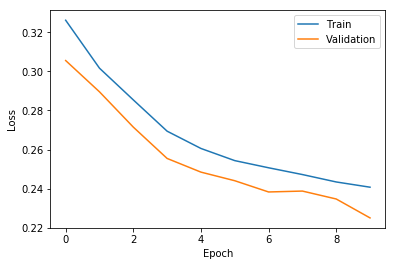

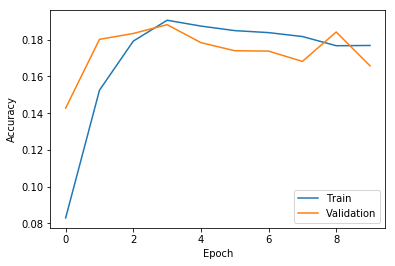

In [9]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [10]:
# Calculate accuracy
print('Training accuracy: {}'.format(test_model(model, train_loader)))
print('Validation accuracy: {}'.format(test_model(model, validation_loader)))
print('Test accuracy: {}'.format(test_model(model, test_loader)))
# Here training accuracy will be higher because dropout is disabled

Training accuracy: 0.150488888889
Validation accuracy: 0.1576
Test accuracy: 0.157


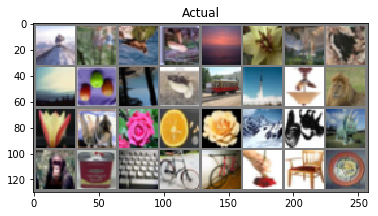

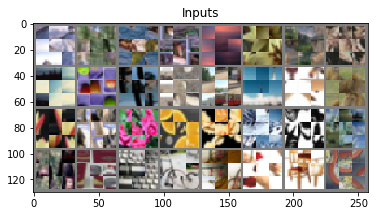

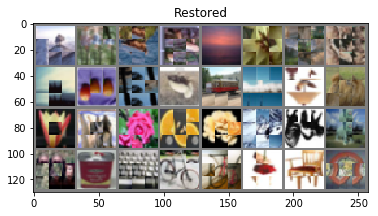

In [12]:
# Let us try some test images.
test_data_iter = iter(test_loader)
test_images, _ = test_data_iter.next()
p_images, perms = permute2x2(test_images)

plt.figure()
imshow(torchvision.utils.make_grid(test_images))
plt.title('Actual')
plt.show()


# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Inputs')
plt.show()

model.eval()
if is_cuda_available:
    pred = model(Variable(p_images.cuda()))
else:
    pred = model(Variable(p_images))
perms_pred = vecmat2perm2x2(pred.cpu().data)

# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms_pred)))
plt.title('Restored')
plt.show()